In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load dataset (Replace 'your_data.csv' with your actual dataset path)
df = pd.read_csv("cleaned_data2_iotid23.csv")


In [3]:
print(df.shape)

(1230402, 35)


In [4]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Length of Fwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Std',
       'Bwd IAT Mean', 'Bwd IAT Std', 'Packet Length Max',
       'Packet Length Mean', 'FIN Flag Count', 'SYN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'Down/Up Ratio',
       'Bwd Bulk Rate Avg', 'FWD Init Win Bytes', 'Bwd Init Win Bytes',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Idle Mean', 'Idle Std', 'Idle Max', 'Connection Type', 'Label'],
      dtype='object')

In [3]:
# Assuming 'label' is the target column
X = df.drop(columns=["Label"])  # Features (34 columns)
y = df["Label"]  # Target


In [4]:
# Encode categorical labels if necessary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [7]:
import numpy as np
import pandas as pd

# Check for infinite values
print("Number of infinite values in X:", np.isinf(X).sum().sum())

# Replace infinite values with NaN (if any)
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for NaN values
print("Number of NaN values in X:", X.isna().sum().sum())

# Fill or drop NaN values
X.fillna(X.median(), inplace=True)  # Replace NaN with median values

Number of infinite values in X: 1830
Number of NaN values in X: 1830


In [8]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [10]:
# Autoencoder Model
dim_input = X_train.shape[1]
encoding_dim = 16  # Choose a lower dimension for the encoded representation

input_layer = Input(shape=(dim_input,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(dim_input, activation="sigmoid")(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

In [11]:
# Train Autoencoder
autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1,
)

Epoch 1/50
30761/30761 [==============================] - 38s 1ms/step - loss: 0.7041 - val_loss: 0.7844
Epoch 2/50
30761/30761 [==============================] - 57s 2ms/step - loss: 0.6948 - val_loss: 0.7833
Epoch 3/50
30761/30761 [==============================] - 40s 1ms/step - loss: 0.6943 - val_loss: 0.7830
Epoch 4/50
30761/30761 [==============================] - 46s 1ms/step - loss: 0.6941 - val_loss: 0.7829
Epoch 5/50
30761/30761 [==============================] - 60s 2ms/step - loss: 0.6940 - val_loss: 0.7828
Epoch 6/50
30761/30761 [==============================] - 42s 1ms/step - loss: 0.6939 - val_loss: 0.7827
Epoch 7/50
30761/30761 [==============================] - 33s 1ms/step - loss: 0.6939 - val_loss: 0.7827
Epoch 8/50
30761/30761 [==============================] - 46s 2ms/step - loss: 0.6938 - val_loss: 0.7826
Epoch 9/50
30761/30761 [==============================] - 49s 2ms/step - loss: 0.6938 - val_loss: 0.7827
Epoch 10/50
30761/30761 [==============================

In [12]:
# Extract Encoder part
encoder = Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

7691/7691 [==============================] - 7s 855us/step


In [13]:
# Train XGBoost on Encoded Features
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
)
xgb_classifier.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
# Predictions
y_pred = xgb_classifier.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9954


c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.99      0.99     65616
           2       1.00      0.99      1.00      9422
           3       1.00      1.00      1.00      1302
           4       1.00      1.00      1.00     44983
           5       1.00      1.00      1.00      7611
           6       0.96      0.99      0.98     14479
           7       1.00      1.00      1.00     88041
           8       1.00      1.00      1.00      2839
           9       1.00      1.00      1.00      3713
          10       0.84      0.42      0.56       144
          11       1.00      1.00      1.00      7929

    accuracy                           1.00    246081
   macro avg       0.90      0.87      0.88    246081
weighted avg       1.00      1.00      1.00    246081



c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(type(xgb))

<class 'module'>


In [19]:
from xgboost import XGBClassifier
import joblib

# Train the model (example)
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(xgb_model, "xgboost_model.pkl")
print("XGBClassifier model saved successfully!")

# Save the StandardScaler
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully!")

XGBClassifier model saved successfully!
Scaler saved successfully!


Classification Report:


c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.99      0.99     65616
           2       1.00      1.00      1.00      9422
           3       1.00      1.00      1.00      1302
           4       1.00      1.00      1.00     44983
           5       1.00      1.00      1.00      7611
           6       0.96      1.00      0.98     14479
           7       1.00      1.00      1.00     88041
           8       0.99      1.00      0.99      2839
           9       1.00      1.00      1.00      3713
          10       0.94      0.92      0.93       144
          11       1.00      1.00      1.00      7929

    accuracy                           1.00    246081
   macro avg       0.91      0.91      0.91    246081
weighted avg       1.00      1.00      1.00    246081



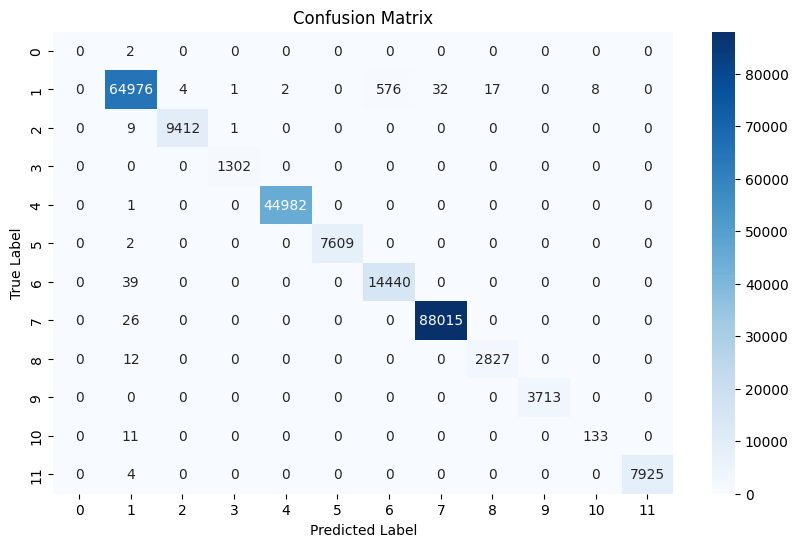

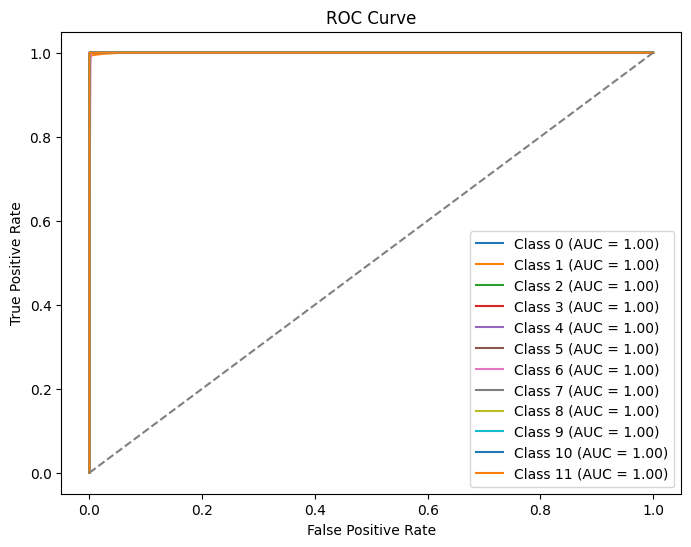

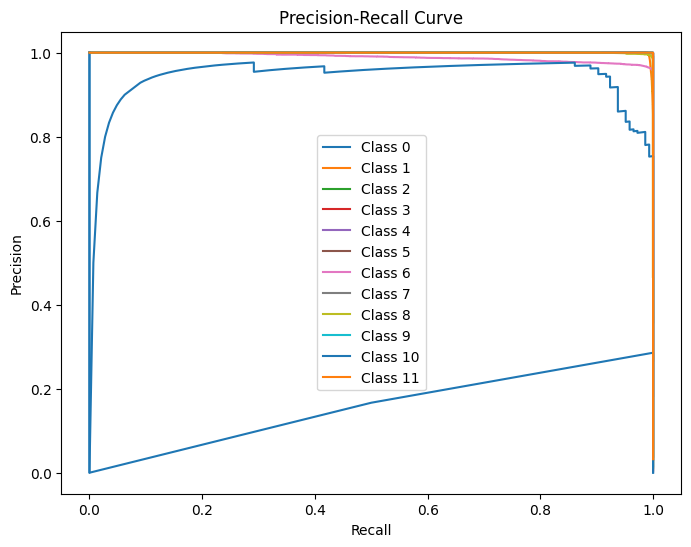

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize

# Predict on test data
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)  # For ROC & PR curves

# 1️⃣ Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 2️⃣ Confusion Matrix
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 3️⃣ ROC Curve (One-vs-Rest for Multi-Class)
n_classes = len(np.unique(y_test))  # Number of classes
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 4️⃣ Precision-Recall Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()